In [5]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from neo4j import GraphDatabase
from tqdm import tqdm

In [6]:
# Setup Neo4j connection
driver = GraphDatabase.driver("bolt://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))

def run_query(tx, query, parameters=None):
    tx.run(query, parameters or {})

def run_cypher(query):
    with driver.session() as session:
        return list(session.run(query))

def run_write_cypher(query):
    with driver.session() as session:
        session.run(query)

# Load DataFrames
report_df = pd.read_csv("data/nodes_report.csv")
temp_df = pd.read_csv("data/edges_temporal.csv")
borders_df = pd.read_csv("data/edges_borders.csv")

In [7]:
print("Dropping old GDS graph")
run_write_cypher("CALL gds.graph.drop('borders_graph', false) YIELD graphName")

print("Creating borders_graph in Neo4j...")
run_write_cypher("""
CALL gds.graph.project(
  'borders_graph',
  'Location',
  {
    BORDERS: { type: 'BORDERS', orientation: 'UNDIRECTED' }
  }
)
""")

Dropping old GDS graph
Creating borders_graph in Neo4j...


In [8]:
louvain_result = run_cypher("""
CALL gds.louvain.stream('borders_graph')
YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).id AS location_id, communityId
ORDER BY communityId
""")

betweenness_result = run_cypher("""
CALL gds.betweenness.stream('borders_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).id AS location_id, score
ORDER BY score DESC
LIMIT 10
""")

pagerank_result = run_cypher("""
CALL gds.pageRank.stream('borders_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).id AS location_id, score
ORDER BY score DESC
LIMIT 10
""")

print("\nLouvain Clustering Results")
for r in louvain_result:
    print(r)

print("\nTop 10 by Betweenness Centrality")
for r in betweenness_result:
    print(r)

print("\nTop 10 by PageRank")
for r in pagerank_result:
    print(r)


Louvain Clustering Results
<Record location_id='ILLINOIS' communityId=8>
<Record location_id='MICHIGAN' communityId=8>
<Record location_id='WISCONSIN' communityId=8>
<Record location_id='IOWA' communityId=8>
<Record location_id='KENTUCKY' communityId=8>
<Record location_id='MISSOURI' communityId=8>
<Record location_id='OHIO' communityId=8>
<Record location_id='INDIANA' communityId=8>
<Record location_id='KANSAS' communityId=11>
<Record location_id='NEBRASKA' communityId=11>
<Record location_id='ARIZONA' communityId=11>
<Record location_id='COLORADO' communityId=11>
<Record location_id='NEW MEXICO' communityId=11>
<Record location_id='UTAH' communityId=11>
<Record location_id='CALIFORNIA' communityId=11>
<Record location_id='OREGON' communityId=11>
<Record location_id='WASHINGTON' communityId=11>
<Record location_id='OKLAHOMA' communityId=11>
<Record location_id='IDAHO' communityId=11>
<Record location_id='NEVADA' communityId=11>
<Record location_id='WYOMING' communityId=11>
<Record lo

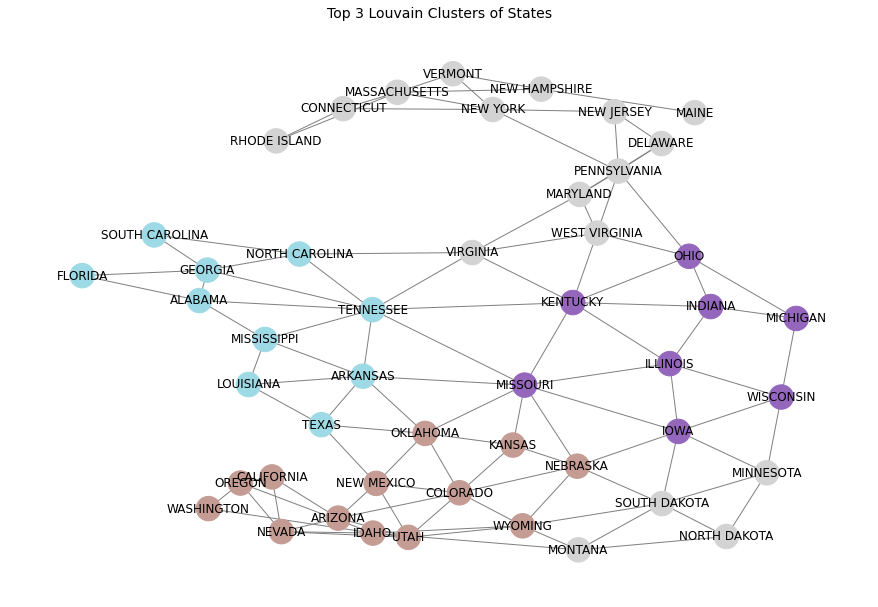

In [9]:
# Convert louvain to clusters
clusters = {}
for record in louvain_result:
    location_id = record["location_id"]
    community_id = record["communityId"]
    clusters[location_id] = community_id

# Count frequencies
cluster_freq = {}
for rec in louvain_result:
    cid = rec["communityId"]
    cluster_freq[cid] = cluster_freq.get(cid, 0) + 1

# Filter to get top 3
sorted_clusters = sorted(cluster_freq.items(), key=lambda x: x[1], reverse=True)
top_clusters = set()
for i in range(min(3, len(sorted_clusters))):
    cid, _ = sorted_clusters[i]
    top_clusters.add(cid)

# Map clusters
filtered_clusters = {}
for state, cid in clusters.items():
    if cid in top_clusters:
        filtered_clusters[state] = cid
    else:
        filtered_clusters[state] = -1

G3 = nx.Graph()
for _, row in borders_df.iterrows():
    G3.add_edge(row["from"], row["to"])

for node in G3.nodes:
    G3.nodes[node]["cluster"] = filtered_clusters.get(node, -1)

plt.figure(figsize=(12, 8))
pos3 = nx.spring_layout(G3, k=0.3, seed=42)

cluster_colors = []
gray_rgba = mcolors.to_rgba("lightgray")
for n in G3.nodes:
    cluster_id = G3.nodes[n]["cluster"]
    if cluster_id != -1:
        color = cm.tab20(cluster_id % 20)
    else:
        color = gray_rgba
    cluster_colors.append(color)

nx.draw(G3, pos3, with_labels=True, node_color=cluster_colors, node_size=600, edge_color="gray")
plt.title("Top 3 Louvain Clusters of States", fontsize=14)
plt.show()

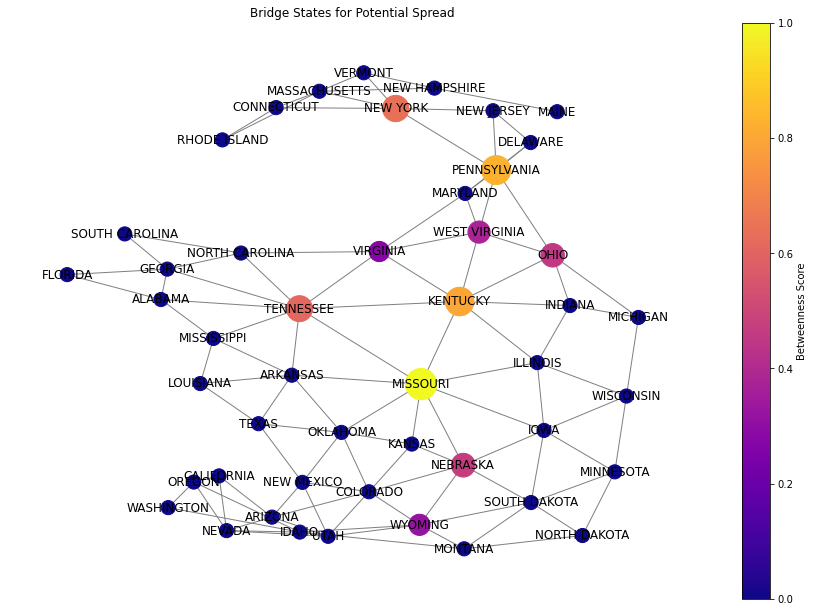

In [10]:
centrality_scores = {}
for r in betweenness_result:
    centrality_scores[r["location_id"]] = r["score"]

# Reuse G3 for betweenness
for node in G3.nodes:
    G3.nodes[node]["centrality"] = centrality_scores.get(node, 0)

plt.figure(figsize=(12, 8))
centrality_sizes = [200 + G3.nodes[n]["centrality"]*2 for n in G3.nodes]
centrality_colors = [G3.nodes[n]["centrality"] for n in G3.nodes]
nx.draw(G3, pos3, with_labels=True, node_size=centrality_sizes,
        node_color=centrality_colors, edge_color="gray", cmap=cm.plasma)
plt.title("Bridge States for Potential Spread")
plt.colorbar(plt.cm.ScalarMappable(cmap=cm.plasma), label="Betweenness Score")
plt.show()

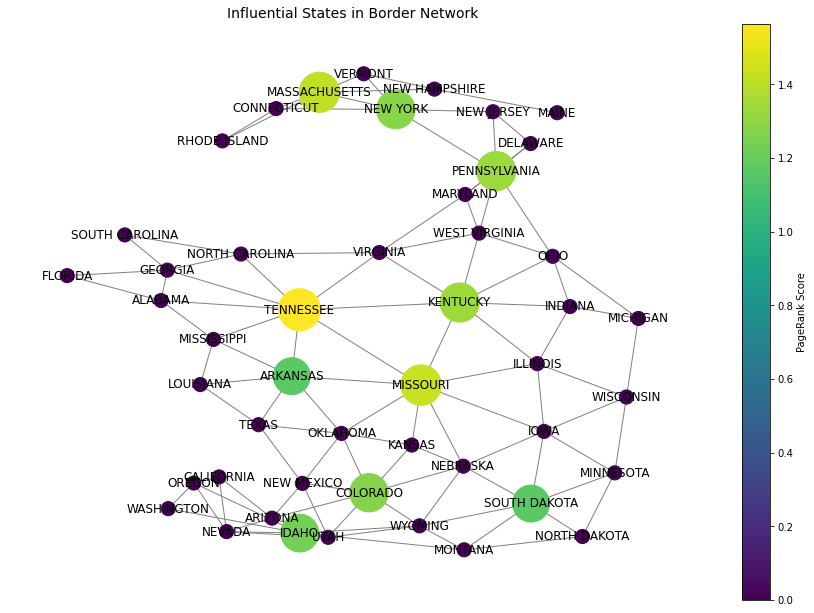

Finished all visualizations and closed the Neo4j driver.


In [11]:
G_pagerank = nx.Graph()
for _, row in borders_df.iterrows():
    G_pagerank.add_edge(row["from"], row["to"])

pagerank_scores = {}
for r in pagerank_result:
    pagerank_scores[r["location_id"]] = r["score"]

for node in G_pagerank.nodes:
    G_pagerank.nodes[node]["pagerank"] = pagerank_scores.get(node, 0)

plt.figure(figsize=(12, 8))
pos_pagerank = nx.spring_layout(G_pagerank, k=0.3, seed=42)

node_sizes = []
node_colors = []

for n in G_pagerank.nodes:
    score = G_pagerank.nodes[n]["pagerank"]
    node_sizes.append(200 + score * 1000)
    node_colors.append(score)

nodes_drawn = nx.draw(
    G_pagerank,
    pos_pagerank,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    cmap=cm.viridis
)

plt.title("Influential States in Border Network", fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array(node_colors)
plt.colorbar(sm, label="PageRank Score")

plt.axis("off")
plt.show()

driver.close()
print("Finished all visualizations and closed the Neo4j driver.")

In [12]:
#CDC Surveillance Data based on 2023 Incidence rate per state https://www.cdc.gov/sti-statistics/data-vis/table-ct-state-ranked.html#toc

data_incidence = [
    {"Rank": 1,  "State": "Louisiana",     "Cases": 36242, "Rate_per_100k": 792.4},
    {"Rank": 2,  "State": "Mississippi",   "Cases": 20603, "Rate_per_100k": 700.9},
    {"Rank": 3,  "State": "Alaska",        "Cases": 5117,  "Rate_per_100k": 697.7},
    {"Rank": 4,  "State": "Alabama",       "Cases": 33261, "Rate_per_100k": 651.1},
    {"Rank": 5,  "State": "Georgia",       "Cases": 71294, "Rate_per_100k": 646.4},
    {"Rank": 6,  "State": "South Carolina","Cases": 32889, "Rate_per_100k": 612.1},
    {"Rank": 7,  "State": "North Carolina","Cases": 65867, "Rate_per_100k": 607.9},
    {"Rank": 8,  "State": "Maryland",      "Cases": 35836, "Rate_per_100k": 579.8},
    {"Rank": 9,  "State": "Arkansas",      "Cases": 17781, "Rate_per_100k": 579.6},
    {"Rank": 10, "State": "New York",      "Cases": 109284,"Rate_per_100k": 558.4},
    {"Rank": 11, "State": "Illinois",      "Cases": 69992, "Rate_per_100k": 557.7},
    {"Rank": 12, "State": "Delaware",      "Cases": 5703,  "Rate_per_100k": 552.7},
    {"Rank": 13, "State": "Arizona",       "Cases": 41058, "Rate_per_100k": 552.5},
    {"Rank": 14, "State": "South Dakota",  "Cases": 4887,  "Rate_per_100k": 531.6},
    {"Rank": 15, "State": "New Mexico",    "Cases": 11071, "Rate_per_100k": 523.6},
    {"Rank": 16, "State": "Tennessee",     "Cases": 36872, "Rate_per_100k": 517.4},
    {"Rank": 17, "State": "Florida",       "Cases": 112804,"Rate_per_100k": 498.9},
    {"Rank": 18, "State": "Missouri",      "Cases": 30892, "Rate_per_100k": 498.6},
    {"Rank": 19, "State": "Nevada",        "Cases": 15766, "Rate_per_100k": 493.6},
    {"Rank": None,"State":"US TOTAL†",     "Cases":1648568,"Rate_per_100k":492.2},  # If you want to include the total
    {"Rank": 20, "State": "Texas",         "Cases": 150056,"Rate_per_100k": 491.9},
    {"Rank": 21, "State": "California",    "Cases": 191357,"Rate_per_100k": 491.1},
    {"Rank": 22, "State": "Indiana",       "Cases": 33693, "Rate_per_100k": 491.0},
    {"Rank": 23, "State": "Rhode Island",  "Cases": 5269,  "Rate_per_100k": 480.8},
    {"Rank": 24, "State": "Virginia",      "Cases": 41206, "Rate_per_100k": 472.8},
    {"Rank": 25, "State": "Oklahoma",      "Cases": 19104, "Rate_per_100k": 471.3},
    {"Rank": 26, "State": "Nebraska",      "Cases": 9274,  "Rate_per_100k": 468.8},
    {"Rank": 27, "State": "Ohio",          "Cases": 54411, "Rate_per_100k": 461.7},
    {"Rank": 28, "State": "Kansas",        "Cases": 13345, "Rate_per_100k": 453.8},
    {"Rank": 29, "State": "North Dakota",  "Cases": 3421,  "Rate_per_100k": 436.4},
    {"Rank": 30, "State": "Hawaii",        "Cases": 6251,  "Rate_per_100k": 435.6},
    {"Rank": 31, "State": "Colorado",      "Cases": 25571, "Rate_per_100k": 435.1},
    {"Rank": 32, "State": "Michigan",      "Cases": 43115, "Rate_per_100k": 429.5},
    {"Rank": 33, "State": "Iowa",          "Cases": 13687, "Rate_per_100k": 426.8},
    {"Rank": 34, "State": "Wisconsin",     "Cases": 24993, "Rate_per_100k": 422.8},
    {"Rank": 35, "State": "Pennsylvania",  "Cases": 54600, "Rate_per_100k": 421.2},
    {"Rank": 36, "State": "Massachusetts", "Cases": 28895, "Rate_per_100k": 412.7},
    {"Rank": 37, "State": "New Jersey",    "Cases": 35689, "Rate_per_100k": 384.1},
    {"Rank": 38, "State": "Kentucky",      "Cases": 17284, "Rate_per_100k": 381.9},
    {"Rank": 39, "State": "Minnesota",     "Cases": 21777, "Rate_per_100k": 379.5},
    {"Rank": 40, "State": "Connecticut",   "Cases": 13197, "Rate_per_100k": 364.8},
    {"Rank": 41, "State": "Oregon",        "Cases": 15344, "Rate_per_100k": 362.5},
    {"Rank": 42, "State": "Washington",    "Cases": 27687, "Rate_per_100k": 354.4},
    {"Rank": 43, "State": "Montana",       "Cases": 3655,  "Rate_per_100k": 322.6},
    {"Rank": 44, "State": "Utah",          "Cases": 11004, "Rate_per_100k": 322.0},
    {"Rank": 45, "State": "Wyoming",       "Cases": 1829,  "Rate_per_100k": 313.2},
    {"Rank": 46, "State": "Idaho",         "Cases": 5793,  "Rate_per_100k": 294.9},
    {"Rank": 47, "State": "West Virginia", "Cases": 4407,  "Rate_per_100k": 249.0},
    {"Rank": 48, "State": "Maine",         "Cases": 3034,  "Rate_per_100k": 217.4},
    {"Rank": 49, "State": "Vermont",       "Cases": 1307,  "Rate_per_100k": 201.9},
    {"Rank": 50, "State": "New Hampshire", "Cases": 2756,  "Rate_per_100k": 196.6},
]

df_incidence = pd.DataFrame(data_incidence)
df_incidence


Rank           State    Cases  Rate_per_100k
0    1.0       Louisiana    36242          792.4
1    2.0     Mississippi    20603          700.9
2    3.0          Alaska     5117          697.7
3    4.0         Alabama    33261          651.1
4    5.0         Georgia    71294          646.4
5    6.0  South Carolina    32889          612.1
6    7.0  North Carolina    65867          607.9
7    8.0        Maryland    35836          579.8
8    9.0        Arkansas    17781          579.6
9   10.0        New York   109284          558.4
10  11.0        Illinois    69992          557.7
11  12.0        Delaware     5703          552.7
12  13.0         Arizona    41058          552.5
13  14.0    South Dakota     4887          531.6
14  15.0      New Mexico    11071          523.6
15  16.0       Tennessee    36872          517.4
16  17.0         Florida   112804          498.9
17  18.0        Missouri    30892          498.6
18  19.0          Nevada    15766          493.6
19   NaN       US TOTAL†  1648568          492.2
20  20.0           Texas   150056          491.9
21  21.0      California   191357          491.1
22  22.0         Indiana    33693          491.0
23  23.0    Rhode Island     5269          480.8
24  24.0        Virginia    41206          472.8
25  25.0        Oklahoma    19104          471.3
26  26.0        Nebraska     9274          468.8
27  27.0            Ohio    54411          461.7
28  28.0          Kansas    13345          453.8
29  29.0    North Dakota     3421          436.4
30  30.0          Hawaii     6251          435.6
31  31.0        Colorado    25571          435.1
32  32.0        Michigan    43115          429.5
33  33.0            Iowa    13687          426.8
34  34.0       Wisconsin    24993          422.8
35  35.0    Pennsylvania    54600          421.2
36  36.0   Massachusetts    28895          412.7
37  37.0      New Jersey    35689          384.1
38  38.0        Kentucky    17284          381.9
39  39.0       Minnesota    21777          379.5
40  40.0     Connecticut    13197          364.8
41  41.0          Oregon    15344          362.5
42  42.0      Washington    27687          354.4
43  43.0         Montana     3655          322.6
44  44.0            Utah    11004          322.0
45  45.0         Wyoming     1829          313.2
46  46.0           Idaho     5793          294.9
47  47.0   West Virginia     4407          249.0
48  48.0           Maine     3034          217.4
49  49.0         Vermont     1307          201.9
50  50.0   New Hampshire     2756          196.6

In [13]:
df_incidence["State_clean"] = df_incidence["State"].str.upper()

In [28]:
incidence_dict = {}
for _, row in df_incidence.iterrows():
    state_id = row["State_clean"]  # or however it matches your node labels
    incidence_dict[state_id] = row["Rate_per_100k"]

In [29]:
for node in G_pagerank.nodes:
    G_pagerank.nodes[node]["incidence"] = incidence_dict.get(node, 0)

In [20]:
cluster_id = G3.nodes[n]["cluster"]
# color is chosen from cluster_id logic

In [30]:
# incidence_dict should map "state_name_or_id" -> incidence_value
for node in G3.nodes:
    # if node is not in incidence_dict, default to 0 or some fallback
    G3.nodes[node]["incidence"] = incidence_dict.get(node, 0)
    

In [35]:
for node in list(G3.nodes)[:10]:  # first 10
    print(node, G3.nodes[node].get("incidence"))

ALABAMA 651.1
FLORIDA 498.9
GEORGIA 646.4
MISSISSIPPI 700.9
TENNESSEE 517.4
ARIZONA 552.5
CALIFORNIA 491.1
COLORADO 435.1
NEVADA 493.6
NEW MEXICO 523.6


In [31]:
incidence_value = G3.nodes[n]["incidence"]
# For a simple scale:
node_size = 200 + 1.0 * incidence_value  # or a sqrt/log scale

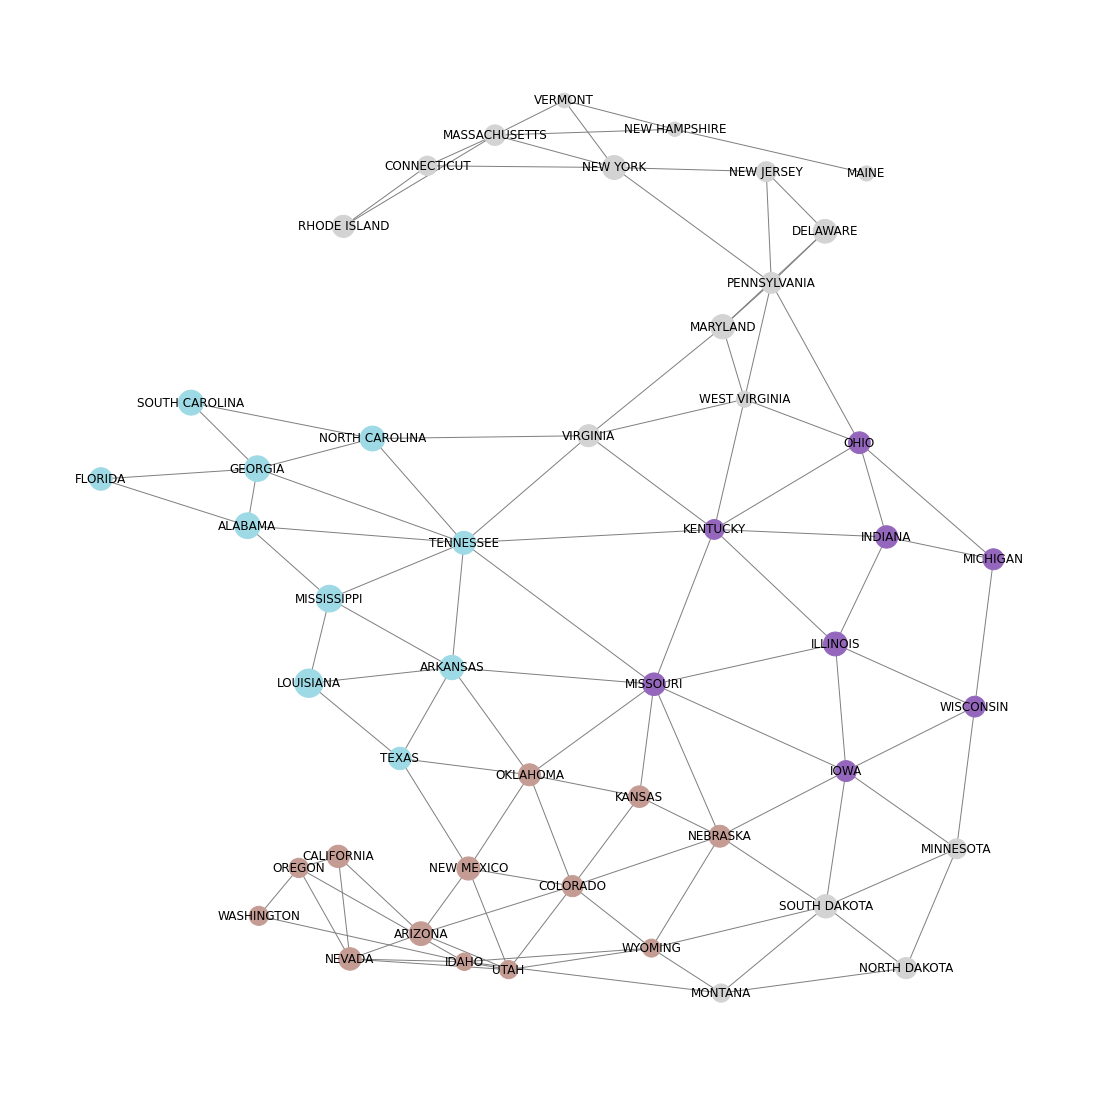

In [53]:
node_sizes = []
for n in G3.nodes:
    inc = G3.nodes[n]["incidence"]
    node_sizes.append(10 + inc)  # or another scaling approach

plt.figure(figsize=(15, 15))
nx.draw(
    G3, 
    pos3, 
    with_labels=True, 
    node_color=cluster_colors, 
    node_size=node_sizes, 
    edge_color="gray"
)

plt.show()

In [25]:
centrality_sizes = [200 + G3.nodes[n]["centrality"]*2 for n in G3.nodes]
centrality_colors = [G3.nodes[n]["centrality"] for n in G3.nodes]


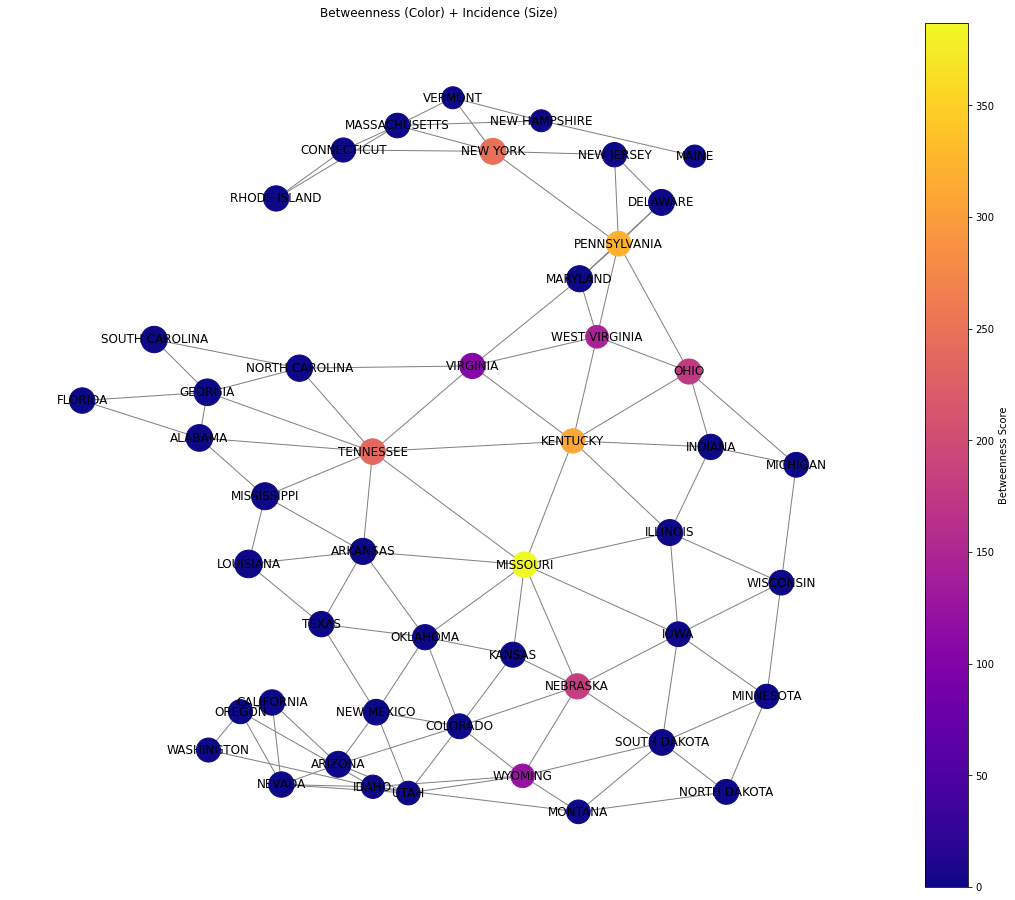

In [56]:
import math

node_sizes = []
node_colors = []

for n in G3.nodes:
    betweenness = G3.nodes[n].get("centrality", 0)
    incidence = G3.nodes[n].get("incidence", 0)
    
    # Let color = betweenness
    node_colors.append(betweenness)
    
    # Let size = some function of incidence
    # e.g., base=200, plus 20x sqrt(incidence) 
    size_val = 200 + 20 * math.sqrt(incidence)
    node_sizes.append(size_val)

plt.figure(figsize=(15, 12))
nx.draw(
    G3,
    pos3,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    cmap=cm.plasma
)

plt.title("Betweenness (Color) + Incidence (Size)")
sm = plt.cm.ScalarMappable(cmap=cm.plasma)
sm.set_array(node_colors)
plt.colorbar(sm, label="Betweenness Score")
plt.show()
